In [ ]:
#importing the necessary libraries.
import re
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def preprocess(tweet):
    tweet = tweet.lower() #lowercasing the tweet content
    tweet = re.sub(r"#(\w+)", r"\1", tweet)  # Removing hashtags but keep the word
    tweet = re.sub(r"http\S+|www.\S+", "<URL>", tweet)  # Replacing URLs with placeholder
    tweet = re.sub(r"@\w+", "<MENTION>", tweet)  # Replacing mentions with placeholder
    tweet = re.sub(r"[^\w\s!?]", "", tweet)  # Removing special characters but keeping ! and ?
    tweet = re.sub(r"\d+", "<NUM>", tweet)  # Replacing numbers with placeholder
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Removing extra spaces
    return tweet

# Loading the dataset
file_path = "//content//sample_data//olid-training-v1.0.tsv"
data = pd.read_csv(file_path, sep="\t")


Training Model for Sub-task A
Best regularization value: 1
Making predictions for Sub-task A
Sub-task A predictions saved to 'subtask_a_predictions.csv'.
Evaluating Sub-task A...
Accuracy (A): 0.7860
NOT - Precision: 0.8528, Recall: 0.8500, F1: 0.8514
OFF - Precision: 0.6157, Recall: 0.6208, F1: 0.6183
Weighted Precision (A): 0.7866
Weighted Recall (A): 0.7860
Weighted F1 Score (A): 0.7863
Macro F1 Score (A): 0.7348



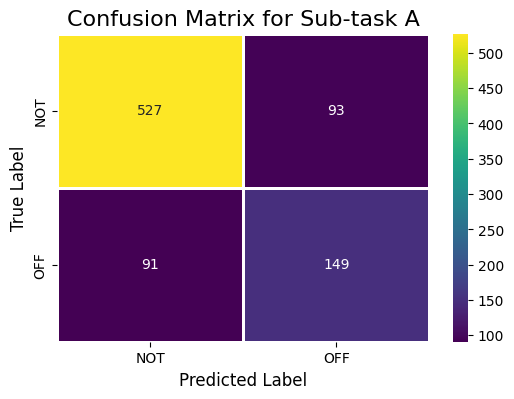

In [ ]:
# Sub-task A: Classifying tweets as Offensive (OFF) or Not Offensive (NOT)
print("Training Model for Sub-task A")

#getting the columns tweet and subtask a and dropping rows with missing values
subtask_a_data = data[['tweet', 'subtask_a']].dropna()

#preprocessing the tweet column and saving the tweets in X_a
X_a = subtask_a_data['tweet'].apply(preprocess)

#getting the labels in subtask A column and saving the labels in y_a
y_a = subtask_a_data['subtask_a']

# Splitting the data into training and testing sets. 20% testing, 80% training
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# converting text data into numerical feature vectors using Term Frequency-Inverse Document Frequency)
# limiting the vocab to the 10,0000 most important terms based on TF-IDF scores
# including both unigrams and bigrams as features.
# removing english stop words to reduce noise
vectorizer_a = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

# fitting the vectorizer to the training data
# - learning the vocab from the training set
# - calculating IDF Inverse Document Frequency for terms
# - transforms training data to sparse matrix representation
X_a_train_vec = vectorizer_a.fit_transform(X_a_train)

# using verctorizer_a, transforms data to sparse matrix using learned vocab and IDF weights from training data
X_a_test_vec = vectorizer_a.transform(X_a_test)

# Defining a range of regularization strengths for Logistic Regression
params = {
    # Regularization strengths to evaluate
    'C': [0.01, 0.1, 0.5, 0.9, 1, 1.1, 2, 10],
}

# GridSearchCV for tuning hyperparameters
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    params, # Testing each value of C using 5-fold cross-validation
    cv=5,  # Splits the training data into 5 subsets for validation
    scoring='f1_macro', # Optimizing the model based on the F1 Macro score
)

# Training the Logistic Regression model:
# - GridSearchCV evaluates the performance of each regularization value using 5-fold cross-validation
# - The model is fitted to the training data (X_a_train_vec, y_a_train)
grid_search.fit(X_a_train_vec, y_a_train)

# Outputting the best value of C:
# - The regularization value that produced the highest F1 Macro score during cross-validation
print(f"Best regularization value: {grid_search.best_params_['C']}")

# Getting the best model from the grid search
model_a = grid_search.best_estimator_

# Loading the test dataset for subtask A
test_a_data = pd.read_csv("//content//sample_data//testset-levela.tsv", sep="\t")

# preprocessing test tweets
test_a_data['tweet'] = test_a_data['tweet'].apply(preprocess)

# Making predictions for the test tweets for Subtask A
print("Making predictions for Sub-task A")
#getting the tweets from the test set
test_a_tweets = test_a_data['tweet']
#converting tweets into TF-IDF features
test_a_vec = vectorizer_a.transform(test_a_tweets)
#predicting labels
test_a_predictions = model_a.predict(test_a_vec)

# Saving predictions to a CSV file
test_a_output = pd.DataFrame({
    #tweet ID
    "id": test_a_data['id'],
    # tweet text
    "tweet": test_a_tweets,
    #predicted label
    "prediction": test_a_predictions
})
test_a_output.to_csv("subtask_a_predictions.csv", index=False)

print("Sub-task A predictions saved to 'subtask_a_predictions.csv'.")

#loading true labels and predictions
labels_a_file = "//content//sample_data//labels-levela.csv"
predictions_a_file = "//content//subtask_a_predictions.csv"

# Loading true labels without headers and assigning column names
true_labels_a = pd.read_csv(labels_a_file, header=None) # loading true labels
true_labels_a.columns = ['id', 'true_label'] # giving column names

# Loading predictions
predictions_a = pd.read_csv(predictions_a_file)

# aligning predictions and true labels by matching their IDs.
y_true_a = true_labels_a.set_index('id')['true_label']
y_pred_a = predictions_a.set_index('id')['prediction']

# Evaluate Sub-task A
print("Evaluating Sub-task A...")

# Overall accuracy
accuracy_a = accuracy_score(y_true_a, y_pred_a)

# Precision, Recall, and F1 for each class
precision_not = precision_score(y_true_a, y_pred_a, pos_label="NOT", average='binary')
recall_not = recall_score(y_true_a, y_pred_a, pos_label="NOT", average='binary')
f1_not = f1_score(y_true_a, y_pred_a, pos_label="NOT", average='binary')

precision_off = precision_score(y_true_a, y_pred_a, pos_label="OFF", average='binary')
recall_off = recall_score(y_true_a, y_pred_a, pos_label="OFF", average='binary')
f1_off = f1_score(y_true_a, y_pred_a, pos_label="OFF", average='binary')

# Weighted averages for precision, recall, and F1
precision_weighted = precision_score(y_true_a, y_pred_a, average='weighted')
recall_weighted = recall_score(y_true_a, y_pred_a, average='weighted')
f1_weighted = f1_score(y_true_a, y_pred_a, average='weighted')

# Macro-F1
f1_a_macro = f1_score(y_true_a, y_pred_a, average='macro')

# overall accuracy
print(f"Accuracy (A): {accuracy_a:.4f}")
#metrics for NOT
print(f"NOT - Precision: {precision_not:.4f}, Recall: {recall_not:.4f}, F1: {f1_not:.4f}")
#metrics for OFF
print(f"OFF - Precision: {precision_off:.4f}, Recall: {recall_off:.4f}, F1: {f1_off:.4f}")
# Weighted averages
print(f"Weighted Precision (A): {precision_weighted:.4f}")
print(f"Weighted Recall (A): {recall_weighted:.4f}")
print(f"Weighted F1 Score (A): {f1_weighted:.4f}")
# Macro-F1
print(f"Macro F1 Score (A): {f1_a_macro:.4f}\n")

# Creating confusion matrix from true labels and predicted labels
conf_matrix = confusion_matrix(y_true_a, y_pred_a, labels=["NOT", "OFF"])
#converting confusion matrix to pandas framework
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["NOT", "OFF"], #index labels
    columns=["NOT", "OFF"] #column labels
)
#setting figure size for heatmap
plt.figure(figsize=(6, 4))
#creating the heatmap
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="viridis", linewidths=1, cbar=True)
#adding title
plt.title("Confusion Matrix for Sub-task A", fontsize=16)
#adding y-axis label
plt.ylabel("True Label", fontsize=12)
#adding x-axis label
plt.xlabel("Predicted Label", fontsize=12)
#displaying the plot
plt.show()

Training Model for Sub-task B
Best value of C: 0.01

Making predictions for Sub-task B
Sub-task B predictions saved to 'subtask_b_predictions.csv'.
Evaluating Sub-task B...
Accuracy (B): 0.8375
TIN - Precision: 0.9307, Recall: 0.8826, F1: 0.9060
UNT - Precision: 0.3421, Recall: 0.4815, F1: 0.4000
Weighted Precision (B): 0.8645
Weighted Recall (B): 0.8375
Weighted F1 Score (B): 0.8491
Macro F1 Score (B): 0.6530



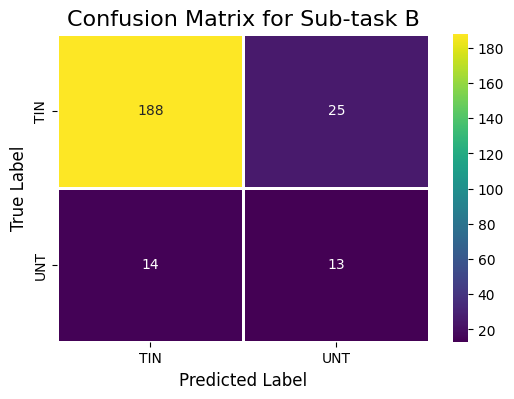

In [ ]:
# Sub-task B: Classifying offensive tweets as Targeted Insult/Threat (TIN) or Untargeted (UNT)
print("Training Model for Sub-task B")


#getting the columns tweet and subtask a and dropping rows with missing values
subtask_b_data = data[['tweet', 'subtask_b']].dropna()
#preprocessing the tweet column
X_b = subtask_b_data['tweet'].apply(preprocess)
#getting the labels in subtask B column
y_b = subtask_b_data['subtask_b']

# Splitting the data into training and testing sets. 20% testing, 80% training
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Converting tweets into numerical feature vectors using Term Frequency-Inverse Document Frequency (TF-IDF)
# Limiting the vocabulary to the top 10,000 most important terms based on TF-IDF scores
# Including both unigrams and bigrams as features
# Removing common English stop words to reduce noise
vectorizer_b = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

# Fitting the vectorizer to the training data:
# - Learning the vocabulary from the training set
# - Calculating Inverse Document Frequency (IDF) for terms
# - Transforming the training data into a sparse matrix representation
X_b_train_vec = vectorizer_b.fit_transform(X_b_train)

# Transforming the test data into a sparse matrix using the learned vocabulary and IDF weights from the training data
X_b_test_vec = vectorizer_b.transform(X_b_test)

# Defining a range of regularization strengths for Logistic Regression
params = {
    # Regularization strengths to evaluate
    'C': [0.0099, 0.01, 0.02, 0.1, 1, 10],  # Regularization strength
}

# GridSearchCV for tuning hyperparameters
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    params, # Testing each value of C using 5-fold cross-validation
    cv=5,  # Splits the training data into 5 subsets for validation
    scoring='f1_macro', # Optimizing the model based on the F1 Macro score
)

# Training the Logistic Regression model:
# - GridSearchCV evaluates the performance of each regularization value using 5-fold cross-validation
# - The model is fitted to the training data (X_b_train_vec, y_b_train)
grid_search.fit(X_b_train_vec, y_b_train)

# Outputting the best value of C:
# - The regularization value that produced the highest F1 Macro score during cross-validation
print(f"Best value of C: {grid_search.best_params_['C']}")

# Getting the best model from the grid search
model_b = grid_search.best_estimator_

# Loading test set for Sub-task B
test_b_data = pd.read_csv("//content//sample_data//testset-levelb.tsv", sep="\t")

# preprocessing test tweets
test_b_data['tweet'] = test_b_data['tweet'].apply(preprocess)

# Making predictions for the test tweets for Subtask B
print("\nMaking predictions for Sub-task B")
#getting the tweets from the test set
test_b_tweets = test_b_data['tweet']
#converting tweets into TF-IDF features
test_b_vec = vectorizer_b.transform(test_b_tweets)
#predicting labels
test_b_predictions = model_b.predict(test_b_vec)

# Saving predictions to a CSV file
test_b_output = pd.DataFrame({
    #tweet ID
    "id": test_b_data['id'],
    # tweet text
    "tweet": test_b_tweets,
    #predicted label
    "prediction": test_b_predictions
})
test_b_output.to_csv("subtask_b_predictions.csv", index=False)

print("Sub-task B predictions saved to 'subtask_b_predictions.csv'.")

# loading true labels and predictions
labels_b_file = "//content//sample_data//labels-levelb.csv"
predictions_b_file = "//content//subtask_b_predictions.csv"

# Loading true labels without headers and assigniging column names
true_labels_b = pd.read_csv(labels_b_file, header=None) # loading true labels
true_labels_b.columns = ['id', 'true_label'] # giving column names

# Loading predictions
predictions_b = pd.read_csv(predictions_b_file)

# aligning predictions and true labels by matching their IDs.
y_true_b = true_labels_b.set_index('id')['true_label']
y_pred_b = predictions_b.set_index('id')['prediction']

# Evaluating Sub-task B
print("Evaluating Sub-task B...")

# Overall accuracy
accuracy_b = accuracy_score(y_true_b, y_pred_b)

# Precision, Recall, and F1 for TIN
precision_tin = precision_score(y_true_b, y_pred_b, pos_label="TIN", average='binary')
recall_tin = recall_score(y_true_b, y_pred_b, pos_label="TIN", average='binary')
f1_tin = f1_score(y_true_b, y_pred_b, pos_label="TIN", average='binary')

# Precision, Recall, and F1 for UNT
precision_unt = precision_score(y_true_b, y_pred_b, pos_label="UNT", average='binary')
recall_unt = recall_score(y_true_b, y_pred_b, pos_label="UNT", average='binary')
f1_unt = f1_score(y_true_b, y_pred_b, pos_label="UNT", average='binary')

# Weighted averages for precision, recall, and F1
precision_weighted_b = precision_score(y_true_b, y_pred_b, average='weighted')
recall_weighted_b = recall_score(y_true_b, y_pred_b, average='weighted')
f1_weighted_b = f1_score(y_true_b, y_pred_b, average='weighted')

# Macro-F1
f1_b_macro = f1_score(y_true_b, y_pred_b, average='macro')

# Printing results

# overall accuracy
print(f"Accuracy (B): {accuracy_b:.4f}")
# metrics for TIN
print(f"TIN - Precision: {precision_tin:.4f}, Recall: {recall_tin:.4f}, F1: {f1_tin:.4f}")
# metrics for UNT
print(f"UNT - Precision: {precision_unt:.4f}, Recall: {recall_unt:.4f}, F1: {f1_unt:.4f}")
# Weighted averages
print(f"Weighted Precision (B): {precision_weighted_b:.4f}")
print(f"Weighted Recall (B): {recall_weighted_b:.4f}")
print(f"Weighted F1 Score (B): {f1_weighted_b:.4f}")
# Macro-F1
print(f"Macro F1 Score (B): {f1_b_macro:.4f}\n")

# Creating confusion matrix from true labels and predicted labels
conf_matrix_b = confusion_matrix(y_true_b, y_pred_b, labels=["TIN", "UNT"])
#converting confusion matrix to pandas framework
conf_matrix_b_df = pd.DataFrame(
    conf_matrix_b,
    index=["TIN", "UNT"], #index labels
    columns=["TIN", "UNT"] #column labels
)
#setting figure size for heatmap
plt.figure(figsize=(6, 4))
#creating the heatmap
sns.heatmap(conf_matrix_b_df, annot=True, fmt="d", cmap="viridis", linewidths=1, cbar=True)
#adding title
plt.title("Confusion Matrix for Sub-task B", fontsize=16)
#adding y-axis label
plt.ylabel("True Label", fontsize=12)
#adding x-axis label
plt.xlabel("Predicted Label", fontsize=12)
#displaying the plot
plt.show()

Training Model for Sub-task C
Best value of C: 0.5

Making predictions for Sub-task C
Sub-task C predictions saved to 'subtask_c_predictions.csv'.
Evaluating Sub-task C
Accuracy (C): 0.6667
IND - Precision: 0.6437, Recall: 0.7179, F1: 0.6788
GRP - Precision: 0.7979, Recall: 0.7500, F1: 0.7732
OTH - Precision: 0.3438, Recall: 0.3143, F1: 0.3284
Weighted Precision (C): 0.6668
Weighted Recall (C): 0.6667
Weighted F1 Score (C): 0.6655
Macro F1 Score (C): 0.5934



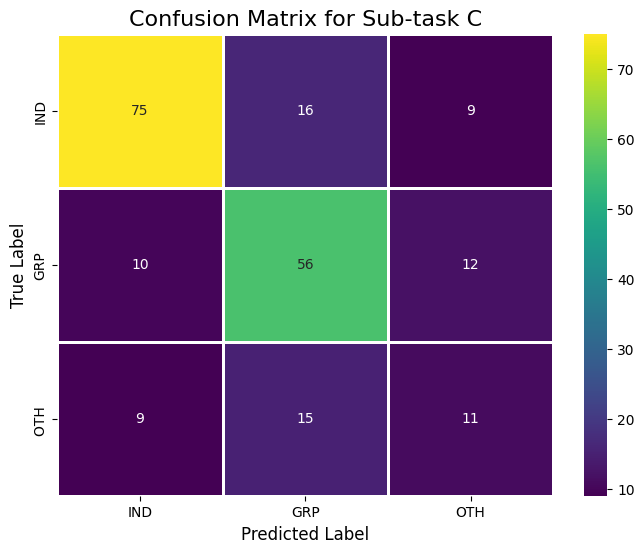

In [ ]:
# Sub-task C: Classifying targeted tweets as either IND, GRP, or OTH
print("Training Model for Sub-task C")

#getting the columns tweet and subtask a and dropping rows with missing values
subtask_c_data = data[['tweet', 'subtask_c']].dropna()
#preprocessing the tweet column
X_c = subtask_c_data['tweet'].apply(preprocess)
#getting the labels in subtask B column
y_c = subtask_c_data['subtask_c']

# Splitting the data into training and testing sets. 20% testing, 80% training
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Converting text data into numerical feature vectors using Term Frequency-Inverse Document Frequency (TF-IDF)
# Limiting the vocabulary to the top 3,000 most important terms based on TF-IDF scores
# Including both unigrams (single words) and bigrams (two-word sequences) as features
vectorizer_c = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))

# Fiting the vectorizer to the training data:
# - Learning the vocabulary from the training set
# - Calculating Inverse Document Frequency (IDF) for terms
# - Transforming the training data into a sparse matrix representation
X_c_train_vec = vectorizer_c.fit_transform(X_c_train)

# Transforming the test data into a sparse matrix using the learned vocabulary and IDF weights from the training dat
X_c_test_vec = vectorizer_c.transform(X_c_test)

# Defining a range of regularization strengths for Logistic Regression
params = {
    # Regularization strengths to evaluate
    'C': [0.01, 0.05, 0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10],  # Regularization strength
}

# GridSearchCV for tuning hyperparameters
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    params, # Testing each value of C using 5-fold cross-validation
    cv=5,  # Splits the training data into 5 subsets for validation
    scoring='f1_macro', # Optimizing the model based on the F1 Macro score
)

# Training the Logistic Regression model:
# - GridSearchCV evaluates the performance of each regularization value using 5-fold cross-validation
# - The model is fitted to the training data (X_c_train_vec, y_c_train)
grid_search.fit(X_c_train_vec, y_c_train)

# Outputting the best value of C:
# - The regularization value that produced the highest F1 Macro score during cross-validation
print(f"Best value of C: {grid_search.best_params_['C']}")

# Getting the best model from the grid search
model_c = grid_search.best_estimator_

# Loading test set for Sub-task C
test_c_data = pd.read_csv("//content//sample_data//testset-levelc.tsv", sep="\t")

# preprocessing test tweets
test_c_data['tweet'] = test_c_data['tweet'].apply(preprocess)

# Making predictions for the test tweets for Subtask C
print("\nMaking predictions for Sub-task C")
#getting the tweets from the test set
test_c_tweets = test_c_data['tweet']
#converting tweets into TF-IDF features
test_c_vec = vectorizer_c.transform(test_c_tweets)
#predicting labels
test_c_predictions = model_c.predict(test_c_vec)

# Saving predictions to a CSV file
test_c_output = pd.DataFrame({
    #tweet id
    "id": test_c_data['id'],
    # tweet text
    "tweet": test_c_tweets,
    # predicted label
    "prediction": test_c_predictions
})
test_c_output.to_csv("subtask_c_predictions.csv", index=False)
print("Sub-task C predictions saved to 'subtask_c_predictions.csv'.")

# File paths for Sub-task C true labels and predictions
labels_c_file = "//content//sample_data//labels-levelc.csv"
predictions_c_file = "//content//subtask_c_predictions.csv"

# Loading true labels without headers and assigning column names
true_labels_c = pd.read_csv(labels_c_file, header=None) # loading true labels
true_labels_c.columns = ['id', 'true_label'] # giving column names

# Loading predictions
predictions_c = pd.read_csv(predictions_c_file)

# aligning predictions and true labels by matching their IDs.
y_true_c = true_labels_c.set_index('id')['true_label']
y_pred_c = predictions_c.set_index('id')['prediction']

# Evaluating Sub-task C
print("Evaluating Sub-task C")

# Overall accuracy
accuracy_c = accuracy_score(y_true_c, y_pred_c)

report = classification_report(
    y_true_c,
    y_pred_c,
    target_names=['IND', 'GRP', 'OTH'],
    output_dict=True
)

# Precision, Recall, and F1 for IND
precision_ind = report['IND']['precision']
recall_ind = report['IND']['recall']
f1_ind = report['IND']['f1-score']

# Precision, Recall, and F1 for GRP
precision_grp = report['GRP']['precision']
recall_grp = report['GRP']['recall']
f1_grp = report['GRP']['f1-score']

# Precision, Recall, and F1 for OTH
precision_oth = report['OTH']['precision']
recall_oth = report['OTH']['recall']
f1_oth = report['OTH']['f1-score']

# Weighted averages for precision, recall, and F1
precision_weighted_c = report['weighted avg']['precision']
recall_weighted_c = report['weighted avg']['recall']
f1_weighted_c = report['weighted avg']['f1-score']

# Macro-F1
f1_c_macro = report['macro avg']['f1-score']

# Printing results:

# overall accuracy
print(f"Accuracy (C): {accuracy_c:.4f}")
# metrics for IND
print(f"IND - Precision: {precision_ind:.4f}, Recall: {recall_ind:.4f}, F1: {f1_ind:.4f}")
# metrics for GRP
print(f"GRP - Precision: {precision_grp:.4f}, Recall: {recall_grp:.4f}, F1: {f1_grp:.4f}")
# metrics for OTH
print(f"OTH - Precision: {precision_oth:.4f}, Recall: {recall_oth:.4f}, F1: {f1_oth:.4f}")
# Weighted averages
print(f"Weighted Precision (C): {precision_weighted_c:.4f}")
print(f"Weighted Recall (C): {recall_weighted_c:.4f}")
print(f"Weighted F1 Score (C): {f1_weighted_c:.4f}")
# Macro-F1
print(f"Macro F1 Score (C): {f1_c_macro:.4f}\n")

# Creating confusion matrix from true labels and predicted labels
conf_matrix_c = confusion_matrix(y_true_c, y_pred_c, labels=["IND", "GRP", "OTH"])
#converting confusion matrix to pandas framework
conf_matrix_c_df = pd.DataFrame(
    conf_matrix_c,
    index=["IND", "GRP", "OTH "], #index labels
    columns=["IND", "GRP", "OTH"] #column labels
)
#setting figure size for heatmap
plt.figure(figsize=(8, 6))
#creating the heatmap
sns.heatmap(conf_matrix_c_df, annot=True, fmt="d", cmap="viridis", linewidths=1, cbar=True)
#adding title
plt.title("Confusion Matrix for Sub-task C", fontsize=16)
#adding y-axis label
plt.ylabel("True Label", fontsize=12)
#adding x-axis label
plt.xlabel("Predicted Label", fontsize=12)
#displaying the plot
plt.show()

**Average Tweet Length Per Sub-task**

In [ ]:
# Calculate tweet lengths and add as new columns
data['tweet_length_char'] = data['tweet'].apply(len)  # Number of characters in each tweet
data['tweet_length_word'] = data['tweet'].apply(lambda x: len(x.split()))  # Number of words in each tweet

# Average lengths per subtask
for subtask, column in [('A', 'subtask_a'), ('B', 'subtask_b'), ('C', 'subtask_c')]:
    if column in data.columns:
        subtask_data = data.dropna(subset=[column])  # Drop rows where the specific subtask label is missing
        avg_char = subtask_data['tweet_length_char'].mean()  # Average tweet length in characters
        avg_word = subtask_data['tweet_length_word'].mean()  # Average tweet length in words
        print(f"Sub-task {subtask}: Avg tweet length (characters): {avg_char:.2f}, (words): {avg_word:.2f}")


Sub-task A: Avg tweet length (characters): 125.91, (words): 22.31
Sub-task B: Avg tweet length (characters): 132.38, (words): 23.61
Sub-task C: Avg tweet length (characters): 135.91, (words): 24.24


**Checking for Duplicate Tweets**

In [ ]:
# Checking for duplicate tweets
duplicate_tweets = data['tweet'].duplicated().sum()
print(f"Number of duplicate tweets in the dataset: {duplicate_tweets}")

Number of duplicate tweets in the dataset: 33


**Sentiment Polarity for Each Sub-task**

In [ ]:
from textblob import TextBlob

# Calculating sentiment polarity for each tweet
data['sentiment'] = data['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
avg_sentiment = data['sentiment'].mean()
print(f"Average sentiment polarity: {avg_sentiment:.2f}")

# Sentiment analysis by subtasks
for subtask, column in [('A', 'subtask_a'), ('B', 'subtask_b'), ('C', 'subtask_c')]:
    if column in data.columns:
        subtask_data = data.dropna(subset=[column])
        avg_sentiment = subtask_data['sentiment'].mean()
        print(f"Sub-task {subtask}: Avg sentiment polarity: {avg_sentiment:.2f}")


Average sentiment polarity: 0.05
Sub-task A: Avg sentiment polarity: 0.05
Sub-task B: Avg sentiment polarity: -0.05
Sub-task C: Avg sentiment polarity: -0.05
